In [1]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tsfeature as tsf
import os

my_path = os.path.abspath('')
my_path = my_path.split('\\')
my_path_py = "\\".join(my_path[:-1])
my_path_py

'C:\\Users\\gioma\\Documents\\GitHub\\Tesis\\Paraguay'

In [2]:
df= pd.read_csv(my_path_py+'\\DatosRaw\\notificaciones_clima_7_dias_COMBINADO_SEMANAL.csv', sep=';')
poblacion= pd.read_csv(my_path_py+'\\DatosRaw\\Poblacion_Paraguay.csv', sep=',')

In [3]:
poblacion['#'] = poblacion['#'].str.upper()
poblacion.rename(columns = {'#':'Ciudad'}, inplace = True)
print("La cantidad de ciudades con casos es:", df['distrito_notif'].nunique())
print("La cantidad de ciudades con datos de población:", poblacion['Ciudad'].nunique())

La cantidad de ciudades con casos es: 238
La cantidad de ciudades con datos de población: 268


In [4]:
S1 = set(list(dict.fromkeys(df['distrito_notif'].tolist())))
S2 = set(list(dict.fromkeys(poblacion['Ciudad'].tolist())))
ciudades = S1.intersection(S2)
df = df[['anio','distrito_notif', 'semana', 'casos']]

In [5]:
df.rename(columns = {'anio':'Año', 'distrito_notif':'Distrito'}, inplace = True)
df = df[df['Distrito'].isin(ciudades)]
listaDistrito = df['Distrito'].tolist()
listaDistrito = list(dict.fromkeys(listaDistrito))
print(len(listaDistrito))

pob = []
for year in list(range(2009,2014)):
    aux = df[df['Año'] == year]
    for dis in aux.Distrito.values:
        pob.append(int(poblacion[poblacion.Ciudad == dis][str(year)].values[0]))  

200


In [6]:
df

,Año,Distrito,semana,casos
0,2009,ASUNCION,2,2
1,2009,FERNANDO DE LA MORA,2,1
2,2009,PEDRO JUAN CABALLERO,2,2
3,2009,YBY YAU,2,4
4,2009,YPANE,2,1
...,...,...,...,...
8482,2013,VILLA HAYES,52,6
8483,2013,VILLETA,52,3
8484,2013,YAGUARON,52,1
8485,2013,YPACARAI,52,2


In [7]:
df['Poblacion'] = pob
df['incidencia'] = (df.casos/df.Poblacion)*100000
df['semana'] = df['semana'] + df['Año'].apply(lambda x: (x-2009)*53 if x>2009 else 0)
df.reset_index(drop=True)

i=0
df1 = df[['Distrito','semana', 'incidencia']]
for dis in listaDistrito:
    df1.loc[df1['Distrito']==dis,'ID_distrito']=i
    i=i+1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


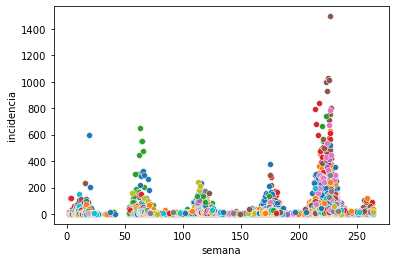

In [8]:
timeSeries = pd.DataFrame()
#listaDistrito = listaDistrito[0:15]
fig = plt.figure()
for dis in listaDistrito:
    distrito=df[df['Distrito']==dis]
    distrito.sort_values(['semana'], ascending = True)
    distrito = distrito.reset_index(drop=True)
    distrito = distrito.replace('nan', np.nan).fillna(0.00000000001)
    distrito = distrito.replace([np.inf, -np.inf], np.nan).fillna(0.00000000001)
    timeSeries = timeSeries.append(distrito['incidencia'], ignore_index=True)
    #print(dis)
    ax = sns.scatterplot(y=distrito['incidencia'], x= distrito['semana'])
plt.savefig(my_path_py + '/Pictures/incidencia.png')
plt.show()

In [9]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
timeSeries = timeSeries.fillna(0.00001)
timeSeries = ss.fit_transform(timeSeries)

## Funciones de Distancias

In [10]:
import math
from math import sqrt, log, floor
from sklearn.metrics import mean_squared_error
from statistics import mean
from fastdtw import fastdtw
from scipy import stats
from scipy.spatial.distance import pdist

#Euclidean
def euclidean(x, y):
    r=np.linalg.norm(x-y)
    if math.isnan(r):
        r=1
    #print(r)
    return r

#Fast Dynamic time warping
def fast_DTW(x, y):
    r, _ = fastdtw(x, y, dist=euclidean)
    if math.isnan(r):
        r=1
    #print(r)
    return r

#Spearman
def scorr(x, y):
    r = stats.spearmanr(x, y)[0]
    if math.isnan(r):
        r=0
    #print(r)
    return 1 - r

#RMSE
def rmse(x, y):
    r=sqrt(mean_squared_error(x,y))
    if math.isnan(r):
        r=1
    #print(r)
    return r

def lcs(a, b):  
    lengths = [[0 for j in range(len(b)+1)] for i in range(len(a)+1)]
    # row 0 and column 0 are initialized to 0 already
    for i, x in enumerate(a):
        for j, y in enumerate(b):
            if x == y:
                lengths[i+1][j+1] = lengths[i][j] + 1
            else:
                lengths[i+1][j+1] = max(lengths[i+1][j], lengths[i][j+1])
    x, y = len(a), len(b)
    result = lengths[x][y]
    return result

def discretise(x):
    return int(x * 10)

def multidim_lcs(a, b):
    a = a.applymap(discretise)
    b = b.applymap(discretise)
    rows, dims = a.shape
    lcss = [lcs(a[i+2], b[i+2]) for i in range(dims)]
    return 1 - sum(lcss) / (rows * dims)

#Correlation
def corr(x, y):
    r=np.dot(x-mean(x),y-mean(y))/((np.linalg.norm(x-mean(x)))*(np.linalg.norm(y-mean(y))))
    if math.isnan(r):
        r=0
    #print(r)
    return 1 - r

In [11]:
n= timeSeries.shape[0]
n

200

In [12]:
timeSeries.shape

(200, 194)

## Matrices de distancias

In [13]:
#Euclidean
euclidean_dist = np.zeros((n,n))
for i in range(0,n):
    #print("i",i)
    for j in range(0,n):
       # print("j",j)
        euclidean_dist[i,j] = euclidean(timeSeries[i,:].flatten(), timeSeries[j].flatten())

#DTW
dtw_dist = np.zeros((n,n))
for i in range(0,n):
    #print("i",i)
    for j in range(0,n):
       # print("j",j)
        dtw_dist[i,j] = fast_DTW(timeSeries[i,:].flatten(), timeSeries[j].flatten())
    

In [14]:
#RMSE
rmse_dist = np.zeros((n,n))
for i in range(0,n):
    #print("i",i)
    for j in range(0,n):
       # print("j",j)
        rmse_dist[i,j] = rmse(timeSeries[i].flatten(), timeSeries[j].flatten())
#Corr
corr_dist = np.zeros((n,n))
for i in range(0,n):
    #print("i",i)
    for j in range(0,n):
       # print("j",j)
        corr_dist[i,j] = corr(timeSeries[i].flatten(), timeSeries[j].flatten())
#scorr
scorr_dist = np.zeros((n,n))
for i in range(0,n):
    #print("i",i)
    for j in range(0,n):
       # print("j",j)
        scorr_dist[i,j] = scorr(timeSeries[i].flatten(), timeSeries[j].flatten())

In [15]:
#timeSeries = timeSeries.replace([np.inf, -np.inf], np.nan).fillna(0.0000001)
from numpy import inf
print('Cantidad de NAN: ', np.any(np.isnan(timeSeries)))
print('Cantidad de INF: ', np.all(np.isfinite(timeSeries)))


timeSeries[timeSeries == inf] = 0
timeSeries[timeSeries == inf] = 0
print('Cantidad de NAN: ', np.any(np.isnan(timeSeries)))
print('Cantidad de INF: ', np.all(np.isfinite(timeSeries)))

Cantidad de NAN:  False
Cantidad de INF:  True
Cantidad de NAN:  False
Cantidad de INF:  True


In [16]:
from tslearn.clustering import TimeSeriesKMeans, KShape, KernelKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

X = timeSeries
model2 = KShape(n_clusters=6, max_iter=10, n_init=2).fit(X)

# K para RawBased

In [17]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

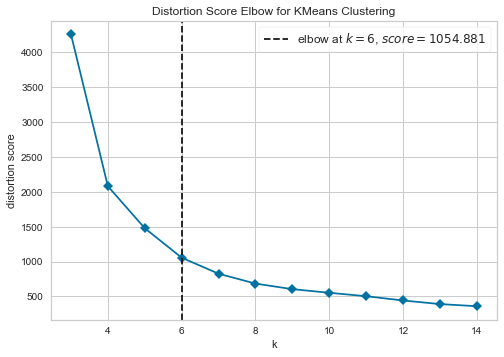

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [18]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,15),metric='distortion', timings=False)
#La metrica distortion comput la suma de cuadrado de las distancias de cada punto al centro, 
#pero se puede usar Silhouette o calinski_harabasz 
visualizer.fit(rmse_dist)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


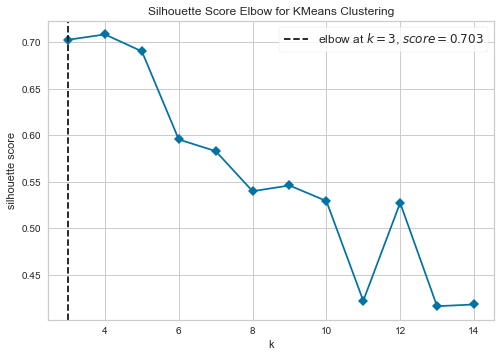

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [19]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,15),metric='silhouette', timings=False)
#La metrica distortion comput la suma de cuadrado de las distancias de cada punto al centro, 
#pero se puede usar Silhouette o calinski_harabasz 
visualizer.fit(rmse_dist)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


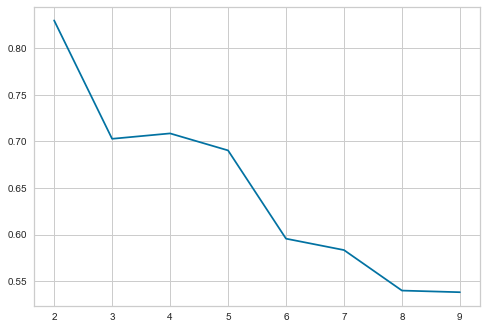

In [21]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

range_n_clusters = list(range(2,10))
silhouette_avg = []
for num_clusters in range_n_clusters:
 
    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(rmse_dist)
    cluster_labels = kmeans.labels_
 
    # silhouette score
    silhouette_avg.append(silhouette_score(rmse_dist, cluster_labels))
plt.plot(range_n_clusters,silhouette_avg, 'bx-')
plt.show()

# K para FeatureBased 2009 al 2013

In [23]:
features= pd.read_csv(my_path_py+'\\2_FeatureBased\\FB2Norm_2009al2013.csv', sep=',')
features = features.drop('Unnamed: 0', axis=1)
lista_distrito1 = features['Distrito'].values.tolist()
features = features.drop('Distrito', axis=1)

In [24]:
n= features.shape[0]
#Euclidean
f_euclidean_dist0913 = np.zeros((n,n))
for i in range(0,n):
    #print("i",i)
    for j in range(1,n):
         f_euclidean_dist0913[i,j] = euclidean(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())

#Corr
f_corr_dist0913 = np.zeros((n,n))
for i in range(0,n):
    for j in range(0,n):
            f_corr_dist0913[i,j] = corr(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())

#scorr
f_scorr_dist0913 = np.zeros((n,n))
for i in range(0,n):
    for j in range(0,n):
        f_scorr_dist0913[i,j] = scorr(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())
#DTW
f_dtw_dist0913 = np.zeros((n,n))
for i in range(0,n):
    for j in range(0,n):
        f_dtw_dist0913[i,j] = fast_DTW(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())

#RMSE
f_rmse_dist0913 = np.zeros((n,n))
for i in range(0,n):
    #print("i",i)
    for j in range(0,n):
       # print("j",j)
        f_rmse_dist0913[i,j] = rmse(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())

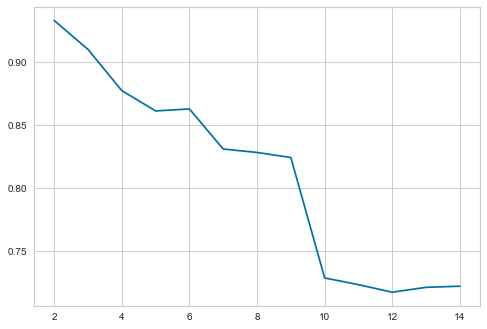

In [26]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
range_n_clusters = list(range(2,15))
silhouette_avg = []
for num_clusters in range_n_clusters:
 
    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(f_rmse_dist0913)
    cluster_labels = kmeans.labels_
 
    # silhouette score
    silhouette_avg.append(silhouette_score(f_rmse_dist0913, cluster_labels))
plt.plot(range_n_clusters,silhouette_avg, 'bx-')
plt.show()

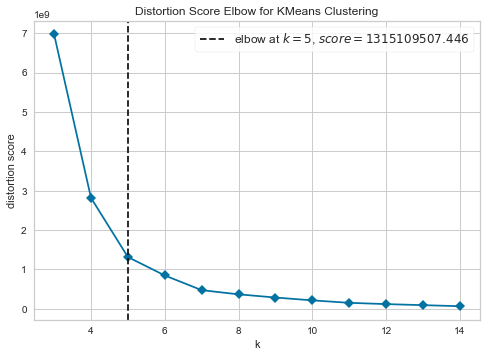

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [27]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,15),metric='distortion', timings=False)

visualizer.fit(f_rmse_dist0913)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

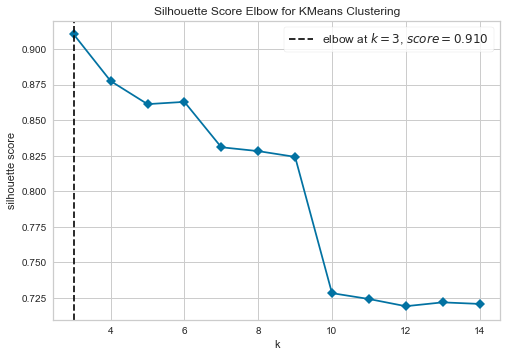

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [28]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,15),metric='silhouette', timings=False)

visualizer.fit(f_rmse_dist0913)        # Fit the data to the visualizer
visualizer.show()    

C:\ProgramData\Anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
C:\ProgramData\Anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
C:\ProgramData\Anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
C:\ProgramData\Anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an unconde

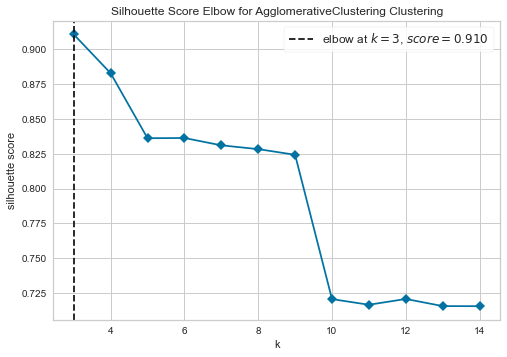

<AxesSubplot:title={'center':'Silhouette Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='silhouette score'>

In [29]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
model = AgglomerativeClustering()
visualizer = KElbowVisualizer(model, k=(3,15),metric='silhouette', timings=False)

visualizer.fit(f_rmse_dist0913)        # Fit the data to the visualizer
visualizer.show()    

# K para FeatureBased 2009 al 2011

In [30]:
features= pd.read_csv(my_path_py+'\\2_FeatureBased\\FB2_2009-2010-2011.csv', sep=',')
features = features.drop('Unnamed: 0', axis=1)
lista_distrito1 = features['Distrito'].values.tolist()
features = features.drop('Distrito', axis=1)

In [31]:
n= features.shape[0]
#Euclidean
f_euclidean_dist = np.zeros((n,n))
for i in range(0,n):
    #print("i",i)
    for j in range(1,n):
         f_euclidean_dist[i,j] = euclidean(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())

#Corr
f_corr_dist = np.zeros((n,n))
for i in range(0,n):
    for j in range(0,n):
            f_corr_dist[i,j] = corr(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())

#scorr
f_scorr_dist = np.zeros((n,n))
for i in range(0,n):
    for j in range(0,n):
        f_scorr_dist[i,j] = scorr(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())
#DTW
f_dtw_dist = np.zeros((n,n))
for i in range(0,n):
    for j in range(0,n):
        f_dtw_dist[i,j] = fast_DTW(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())

#RMSE
rmse_dist = np.zeros((n,n))
for i in range(0,n):
    #print("i",i)
    for j in range(0,n):
       # print("j",j)
        rmse_dist[i,j] = rmse(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())

C:\ProgramData\Anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
C:\ProgramData\Anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
C:\ProgramData\Anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
C:\ProgramData\Anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an unconde

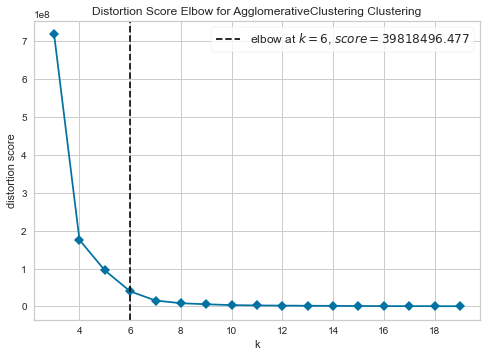

<AxesSubplot:title={'center':'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [32]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
model = AgglomerativeClustering()
visualizer = KElbowVisualizer(model, k=(3,20),metric='distortion', timings=False)

visualizer.fit(rmse_dist)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# Gráficos de rangos de K vs Silhouette score  

In [34]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
range_n_clusters = list(range(2,10))
silhouette_avg = []
for num_clusters in range_n_clusters:
 
    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(f_euclidean_dist)
    cluster_labels = kmeans.labels_
 
    # silhouette score
    silhouette_avg.append(silhouette_score(data_frame, cluster_labels))

plt.plot(range_n_clusters,silhouette_avg, 'bx-')
plt.xlabel('Valores de K') 
plt.ylabel('Puntaje Silhouette') 
plt.title('Puntaje Silhouette vs Número de clústeres (K)')
plt.show()

NameError: name 'data_frame' is not defined

In [36]:
range_n_clusters = list(range(2,10))
silhouette_avg = []
for num_clusters in range_n_clusters:
 
    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(f_euclidean_dist)
    cluster_labels = kmeans.labels_
 
    # silhouette score
    silhouette_avg.append(silhouette_score(data_frame, cluster_labels))

plt.plot(range_n_clusters,silhouette_avg, 'bx-')
plt.xlabel('Valores de K') 
plt.ylabel('Puntaje Silhouette') 
plt.title('Puntaje Silhouette vs Número de clústeres (K)')
plt.show()

NameError: name 'data_frame' is not defined

In [ ]:
# Dendogram for Heirarchical Clustering
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot

pyplot.figure(figsize=(10, 7))  
pyplot.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(f_rmse_dist0913, method='ward'))